In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold 
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [4]:
# Loading the dataset
# Reading dataset
dataset = pd.read_table('ratings.dat', header = None, sep = '::', engine = 'python', usecols = [0,1,2], names = ('UserID','MovieID', 'Ratings'))

dataset.head()

# Are there missing values?
dataset.isna().sum()


# Keep in mind that there are “gaps” in numbering of users and items. (Dictionaries? Renumber everything? …)
# What is meant with this??

UserID     0
MovieID    0
Ratings    0
dtype: int64

In [47]:
dataset['Ratings'].value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Ratings, dtype: int64

KeyboardInterrupt: 

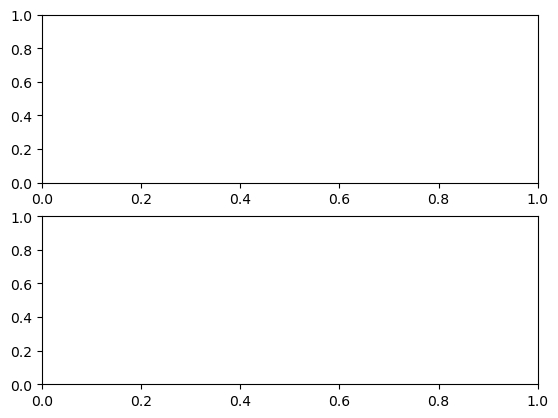

In [48]:
#test + optimization cell
import time
start = time.time()
#initialize params
fig, (ax1, ax2) = plt.subplots(2)
n_iter = 0
rme_list = list()
MAE_list = list()
n_splits = 5
Threshold = 0.0001
KF = KFold(n_splits=5, random_state=123, shuffle=True)
#Kfold loop (5 datasets)
for Train, Test in KF.split(dataset):
    dataset_2_Train, dataset_2_Test = dataset.loc[Train], dataset.loc[Test]
    dataset_split = dataset_2_Train.pivot(
    index='UserID',
    columns='MovieID',
    values='Ratings'
    )
    dataset1 = dataset_split.sub(dataset_split.mean(axis = 1), axis=0)
    dataset_end = dataset1.sub(dataset1.mean(axis = 0), axis = 1)
    dataset_split = dataset_end
    M = dataset_split.to_numpy()
    d = 2
    n = dataset_split.shape[0]
    m = dataset_split.shape[1]
    a = dataset_split.stack().mean()
    U = np.empty([n,d])
    V = np.empty([d,m])
    V = np.random.randn(d, m) # random numbers to increase chance of reachine global minimum
    U = np.random.randn(n, d)
    uv = np.matmul(U,V)
    
    halt = True
    n_iter += 1
    n_loop = 1
    l_RMSE_loop = list()
    l_MAE_loop = list()
    #calculate initial RMSE
    dif_squared_0 = np.nan_to_num(np.square(np.subtract(uv, M)))
    dif_squared_total_sum = np.sum(dif_squared_0)
    N_non_0 = np.count_nonzero(dif_squared_0)
    RME = np.divide(dif_squared_total_sum, N_non_0)
    RMSE = np.sqrt(RME)
    l_RMSE_loop.append(RMSE)
    #calculate initial MAE
    dif_abs = np.nan_to_num(np.abs(np.subtract(uv, M)))
    dif_abs_sum = np.sum(dif_abs)
    N_non_0_abs = np.count_nonzero(dif_abs)
    MAE = np.divide(dif_abs_sum, N_non_0_abs)
    l_MAE_loop.append(MAE)
    #iterate as long as change of RME is bigger than threshold
    while halt:
        RME_old = RMSE
        n_loop+=1
        #update U matrix
        for r in range(U.shape[0]):
            numerator = 0
            denominator = 0

            for s in range(d):
                U_rk = U[r,:]
                U_rk = np.delete(U_rk, s, 0)
                V_kj = np.delete(V, s, 0)
                V_sj = V[s,:]
                P = np.matmul(U_rk, V_kj)
                m_rj = M[r,:]
                numerator = np.multiply(V_sj,(np.subtract(m_rj, P)))
                numerator = np.nansum(np.multiply(numerator, (np.isfinite(m_rj))))
                denominator = np.square(V_sj)
                denominator = np.nansum(np.multiply(denominator, (np.isfinite(m_rj))))
                new_var = np.divide(numerator, denominator)
                U[r,s] = new_var
        #update V matrix
        for r in range(d):
            for s in range(V.shape[1]):
                V_ks = V[:,s]
                V_ks = np.delete(V_ks, r, 0)
                U_ik = np.delete(U, r, 1)
                U_ir = U[:,r]
                P = np.matmul(U_ik, V_ks)
                m_is = M[:,s]
                numerator = np.multiply(U_ir, (np.subtract(m_is, P)))
                numerator = np.nansum(np.multiply(numerator, (np.isfinite(m_is))))
                denominator = np.square(U_ir)
                denominator = np.nansum(np.multiply(denominator, (np.isfinite(m_is))))
                newvar = np.divide(numerator, denominator)
                V[r,s] = newvar
        #matrix multiplication and comparison to original matrix M + calc MSE
        uv = np.matmul(U,V)
        #calc RMSE
        dif_squared_0 = np.nan_to_num(np.square(np.subtract(uv, M)))
        dif_squared_total_sum = np.sum(dif_squared_0)
        N_non_0 = np.count_nonzero(dif_squared_0)
        RME = np.divide(dif_squared_total_sum, N_non_0)
        RMSE = np.sqrt(RME)
        halt = np.abs(RMSE - RME_old) > Threshold
        l_RMSE_loop.append(RMSE)
        #calc MAE
        dif_abs = np.nan_to_num(np.abs(np.subtract(uv, M)))
        dif_abs_sum = np.sum(dif_abs)
        N_non_0_abs = np.count_nonzero(dif_abs)
        MAE = np.divide(dif_abs_sum, N_non_0_abs)
        l_MAE_loop.append(MAE)
    print(f'fold {n_iter}; RMSE = {RMSE}')
    print(f'fold {n_iter}; MAE = {MAE}')
    rme_list.append(RMSE)
    MAE_list.append(MAE)
    ax1.plot(range(n_loop), l_RMSE_loop, label = f'Iteration Kfold: {n_iter}')
    ax2.plot(range(n_loop), l_MAE_loop, label = f'Iteration Kfold: {n_iter}')

rme_list_mean = np.mean(rme_list)
MAE_list_mean = np.mean(MAE_list)
print(f'Average RMSE over {n_iter} folds = {rme_list_mean}')
print(f'Average MAE over {n_iter} folds = {MAE_list_mean}')
plt.suptitle("UV Matrix decomposition")
plt.xlabel("Number of loops")
ax1.set_ylabel("RMSE")
ax1.legend()
ax2.set_ylabel("MAE")
ax2.legend()
plt.savefig("Figure.png")
plt.show()
ende = time.time()
print('Total runtime = ', (ende - start))

C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:72: RuntimeWarning: invalid value encountered in true_divide
  new_var = np.divide(numerator, denominator)
C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:87: RuntimeWarning: invalid value encountered in true_divide
  newvar = np.divide(numerator, denominator)


fold 1; RMSE = 3.1350587381005885
fold 1; MAE = 2.7342574424343145
fold 1; RMSE = 1.0879093528052872
fold 1; MAE = 0.8408795148538317
fold 1; RMSE = 0.9052848925765615
fold 1; MAE = 0.7127110821645787
fold 1; RMSE = 0.8888040399606647
fold 1; MAE = 0.7018247433898167


C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:72: RuntimeWarning: invalid value encountered in true_divide
  new_var = np.divide(numerator, denominator)
C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:87: RuntimeWarning: invalid value encountered in true_divide
  newvar = np.divide(numerator, denominator)


fold 2; RMSE = 3.281361828515828
fold 2; MAE = 2.9426128346297467
fold 2; RMSE = 1.1357269992388601
fold 2; MAE = 0.8760951013265188
fold 2; RMSE = 0.917845925594487
fold 2; MAE = 0.7247727908510864
fold 2; RMSE = 0.8997357648494176
fold 2; MAE = 0.7114036026125699


C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:72: RuntimeWarning: invalid value encountered in true_divide
  new_var = np.divide(numerator, denominator)
C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:87: RuntimeWarning: invalid value encountered in true_divide
  newvar = np.divide(numerator, denominator)


fold 3; RMSE = 3.053675458555221
fold 3; MAE = 2.6203848020187253
fold 3; RMSE = 1.0163211037341082
fold 3; MAE = 0.7939855642482732
fold 3; RMSE = 0.9049130536438447
fold 3; MAE = 0.7147023524150042
fold 3; RMSE = 0.8951796988642049
fold 3; MAE = 0.7072487554022081


C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:72: RuntimeWarning: invalid value encountered in true_divide
  new_var = np.divide(numerator, denominator)
C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:87: RuntimeWarning: invalid value encountered in true_divide
  newvar = np.divide(numerator, denominator)


fold 4; RMSE = 3.036986521446935
fold 4; MAE = 2.591377810471308
fold 4; RMSE = 1.0571594240355215
fold 4; MAE = 0.8175389003132211
fold 4; RMSE = 0.9161546993162613
fold 4; MAE = 0.7225102340191087
fold 4; RMSE = 0.9016511326986301
fold 4; MAE = 0.7119221990038197


C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:72: RuntimeWarning: invalid value encountered in true_divide
  new_var = np.divide(numerator, denominator)
C:\Users\Nick\AppData\Local\Temp\ipykernel_6864\499192093.py:87: RuntimeWarning: invalid value encountered in true_divide
  newvar = np.divide(numerator, denominator)


fold 5; RMSE = 3.288953636549252
fold 5; MAE = 2.9507047071578274
fold 5; RMSE = 1.256068334588551
fold 5; MAE = 0.9499984720212505
fold 5; RMSE = 0.9323544238528602
fold 5; MAE = 0.7336226982676327
fold 5; RMSE = 0.9026852048773361
fold 5; MAE = 0.7123022255902058
Average RMSE over 5 folds = 0.8976111682500507
Average MAE over 5 folds = 0.7089403051997241


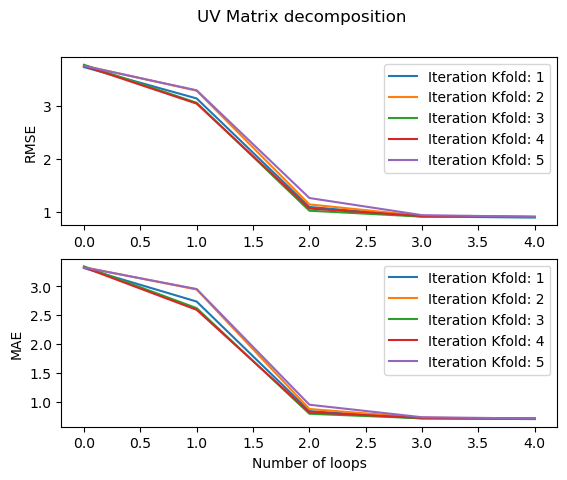

Total runtime =  103.85552859306335


In [88]:
#test + optimization cell no use
import time
start = time.time()
#initialize params
fig, (ax1, ax2) = plt.subplots(2)
n_iter = 0
rme_list = list()
MAE_list = list()
n_splits = 5
Threshold = 0.1
KF = KFold(n_splits=5, random_state=123, shuffle=True)
#Kfold loop (5 datasets)
for Train, Test in KF.split(dataset):
    dataset_2_Train, dataset_2_Test = dataset.loc[Train], dataset.loc[Test]
    dataset_split = dataset_2_Train.pivot(
    index='UserID',
    columns='MovieID',
    values='Ratings'
    )
    dataset1 = dataset_split.sub(dataset_split.mean(axis = 1), axis=0)
    dataset_end = dataset1.sub(dataset_split.mean(axis = 0), axis = 0)
    dataset_split = dataset_end
    M = dataset_split.to_numpy()
    d = 2
    n = dataset_split.shape[0]
    m = dataset_split.shape[1]
    a = dataset_split.stack().mean()
    U = np.empty([n,d])
    V = np.empty([d,m])
    V = np.random.randn(d, m) # random numbers to increase chance of reachine global minimum
    U = np.random.randn(n, d)
    uv = np.matmul(U,V)
    
    halt = True
    n_iter += 1
    n_loop = 1
    l_RMSE_loop = list()
    l_MAE_loop = list()
    #calculate initial RMSE
    dif_squared_0 = np.nan_to_num(np.square(np.subtract(uv, M)))
    dif_squared_total_sum = np.sum(dif_squared_0)
    N_non_0 = np.count_nonzero(dif_squared_0)
    RME = np.divide(dif_squared_total_sum, N_non_0)
    RMSE = np.sqrt(RME)
    l_RMSE_loop.append(RMSE)
    #calculate initial MAE
    dif_abs = np.nan_to_num(np.abs(np.subtract(uv, M)))
    dif_abs_sum = np.sum(dif_abs)
    N_non_0_abs = np.count_nonzero(dif_abs)
    MAE = np.divide(dif_abs_sum, N_non_0_abs)
    l_MAE_loop.append(MAE)
    #iterate as long as change of RME is bigger than threshold
    while halt:
        RME_old = RMSE
        n_loop+=1
        #update U matrix
        for r in range(U.shape[0]):
            numerator = 0
            denominator = 0

            for s in range(d):
                U_rk = U[r,:]
                U_rk = np.delete(U_rk, s, 0)
                V_kj = np.delete(V, s, 0)
                V_sj = V[s,:]
                P = np.matmul(U_rk, V_kj)
                m_rj = M[r,:]
                numerator = np.multiply(V_sj,(np.subtract(m_rj, P)))
                numerator = np.nansum(np.multiply(numerator, (np.isfinite(m_rj))))
                denominator = np.square(V_sj)
                denominator = np.nansum(np.multiply(denominator, (np.isfinite(m_rj))))
                new_var = np.divide(numerator, denominator)
                U[r,s] = new_var
        #update V matrix
        for r in range(d):
            for s in range(V.shape[1]):
                V_ks = V[:,s]
                V_ks = np.delete(V_ks, r, 0)
                U_ik = np.delete(U, r, 1)
                U_ir = U[:,r]
                P = np.matmul(U_ik, V_ks)
                m_is = M[:,s]
                numerator = np.multiply(U_ir, (np.subtract(m_is, P)))
                numerator = np.nansum(np.multiply(numerator, (np.isfinite(m_is))))
                denominator = np.square(U_ir)
                denominator = np.nansum(np.multiply(denominator, (np.isfinite(m_is))))
                newvar = np.divide(numerator, denominator)
                V[r,s] = newvar
        #matrix multiplication and comparison to original matrix M + calc MSE
        uv = np.matmul(U,V)
        #calc RMSE
        dif_squared_0 = np.nan_to_num(np.square(np.subtract(uv, M)))
        dif_squared_total_sum = np.sum(dif_squared_0)
        N_non_0 = np.count_nonzero(dif_squared_0)
        RME = np.divide(dif_squared_total_sum, N_non_0)
        RMSE = np.sqrt(RME)
        halt = np.abs(RMSE - RME_old) > Threshold
        l_RMSE_loop.append(RMSE)
        #calc MAE
        dif_abs = np.nan_to_num(np.abs(np.subtract(uv, M)))
        dif_abs_sum = np.sum(dif_abs)
        N_non_0_abs = np.count_nonzero(dif_abs)
        MAE = np.divide(dif_abs_sum, N_non_0_abs)
        l_MAE_loop.append(MAE)
        print(f'fold {n_iter}; RMSE = {RMSE}')
        print(f'fold {n_iter}; MAE = {MAE}')
    rme_list.append(RMSE)
    MAE_list.append(MAE)
    ax1.plot(range(n_loop), l_RMSE_loop, label = f'Iteration Kfold: {n_iter}')
    ax2.plot(range(n_loop), l_MAE_loop, label = f'Iteration Kfold: {n_iter}')

rme_list_mean = np.mean(rme_list)
MAE_list_mean = np.mean(MAE_list)
print(f'Average RMSE over {n_iter} folds = {rme_list_mean}')
print(f'Average MAE over {n_iter} folds = {MAE_list_mean}')
plt.suptitle("UV Matrix decomposition")
plt.xlabel("Number of loops")
ax1.set_ylabel("RMSE")
ax1.legend()
ax2.set_ylabel("MAE")
ax2.legend()
plt.savefig("Figure.png")
plt.show()
ende = time.time()
print('Total runtime = ', (ende - start))

In [109]:
dataset_split = dataset_2_Train.pivot(
index='UserID',
columns='MovieID',
values='Ratings'
)
mean1 = dataset_split.mean(axis = 1)
mean2 = dataset_split.mean(axis = 0)

AttributeError: 'numpy.ndarray' object has no attribute 'add'

In [ ]:
    dataset1 = dataset_split.sub(dataset_split.mean(axis = 1), axis=0)
    dataset_end = dataset1.sub(dataset_split.mean(axis = 0), axis = 0)